In [1]:
%run init_notebook.py

In [2]:
import pandas as pd
import numpy as np

import os
import datetime as dt
from functools import wraps

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from settings import RAW_DATA_DIR, WORK_DATA_DIR, OUT_DATA_DIR, OUT_MODEL_DIR, random_state
from utils.utils import *
from utils.load import load_data, save_file, save_model
from utils.cast_data import apply_datetime_format
from utils.plotting import *
from src.src import *

In [4]:
# load data
df_all = load_data(file_name="merged_data.csv", file_path=WORK_DATA_DIR)
df_all.sort_values("date", inplace=True)
data_dict = load_data(file_name="data_dict.pkl", file_path=WORK_DATA_DIR)

('nan format unknonw',)
Unknown columns found
['date']


In [5]:
# select relevant data
drop_cols = data_dict["data_cols"]["fears"] + data_dict["data_cols"]["goog_sent"]
df_w = df_all.drop(drop_cols, axis=1).copy()

# get data on weekly basis
df_w = cut_to_weekly_data(df_w).reset_index(drop=True)

# get lead variable as target
# get lag variable as X
df_w = shift_var_relative_to_df(df_w, shift_var="sp_close", new_var_name=["sp_close_lead1"], no_lags=[-1])
df_w = shift_var_relative_to_df(df_w, shift_var="sp_close", new_var_name=["sp_close_lag1", "sp_close_lag2", "sp_close_lag3"], no_lags=[1, 2, 3])

Applying shifts in future


In [6]:
df_w["sp_agg1"] = df_w.sp_close_lag1 + df_w.sp_close_lag2 + df_w.sp_close_lag3
df_w["sp_true_vals"] = df_w["sp_close"]

In [7]:
# edit data_dict
data_dict.update(predicted="sp_close_lead1")
data_dict.update(sp_true_vals="sp_true_vals")
data_dict.update(sp_cols=["sp_close", "sp_close_lead1", "sp_close_lag1", "sp_close_lag2", "sp_close_lag3", "sp_agg1"])


relevant_cols=[
    # 'fears35',
    'vixo',
    'naaim_ind',
    'ff_M_RF',
    'ff_SMB',
    'ff_HML',
    'ff_RMW',
    'ff_CMA',
    # 'ff_RF',
    'termspread',
    'pc_ratio',
    'aaii_Bullish',
    # 'goog_sent'
] 
relevant_cols = relevant_cols + data_dict["sp_cols"]

data_dict.update(relevant_cols=relevant_cols)
data_dict.update(predictor=[item for item in data_dict["relevant_cols"] if item != data_dict["predicted"]])

In [8]:
def translate_neg_dist(arr):
    if min(arr) <= 0:
        return True, arr + (abs(arr.min()) + 1)
    else:
        return False, arr
    pass


def arr_log_return(arr: pd.Series):
    # Assumption, df is ordered past to future
    is_trans, arr = translate_neg_dist(arr)
    return is_trans, np.log(1 + arr.pct_change())

In [25]:
def df_log_return(df_in: pd.DataFrame,
                  cols: list):
    
    df = df_in.copy()    
    dist_trans = []
    
    for col in cols:
        is_trans, df[col] = arr_log_return(df[col])
        dist_trans.append(is_trans)
    
    dist_translation = dict(zip(cols, dist_trans))
    log_returns = dict(zip(cols, list([True] * len(cols))))
    
    df.dropna(inplace=True)
        
    return df, dist_translation, log_returns

In [34]:
def update_dict(dict_in: dict,
                update_keys: list,
                update_vals: list):
    dict_ = dict_in.copy()
    
    for i, key in enumerate(update_keys):
        print(key)
        dict_[key] = update_vals[i]
        
    return dict_

In [35]:
df_w, dist, log = df_log_return(df_w,
                                cols=data_dict["relevant_cols"])

update_dict(data_dict,
            update_keys=["dist_translation", "log_return"],
            update_vals=[dist, log])

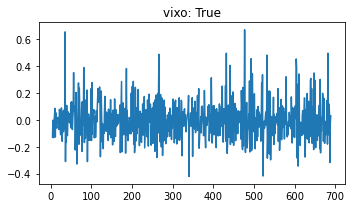

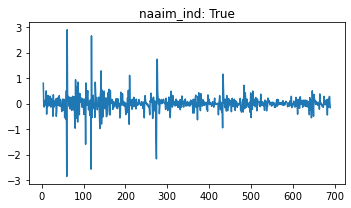

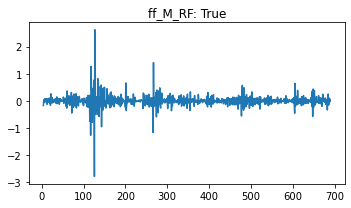

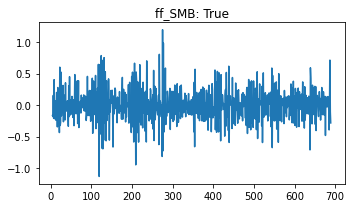

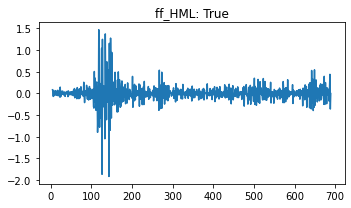

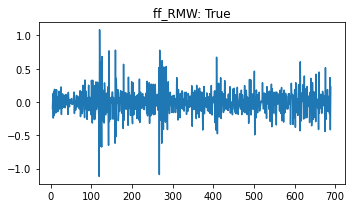

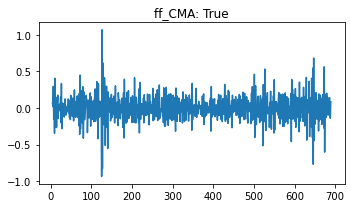

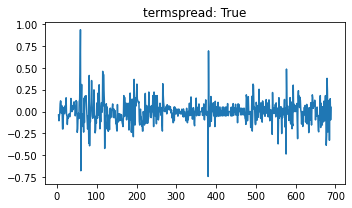

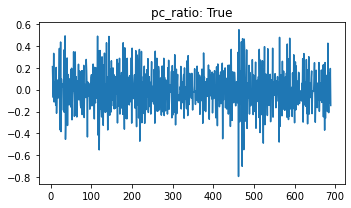

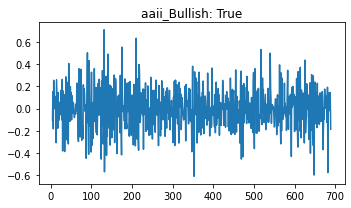

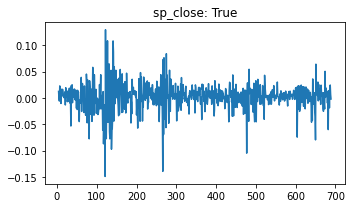

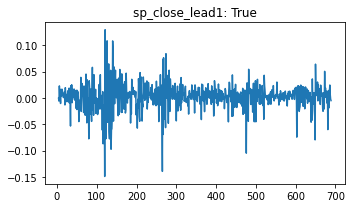

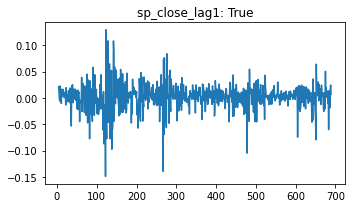

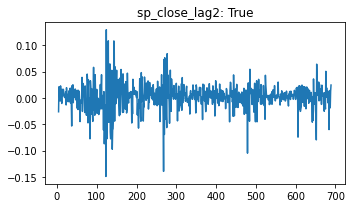

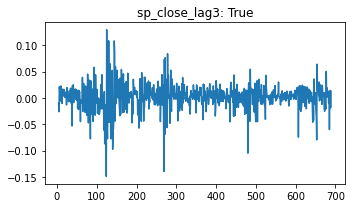

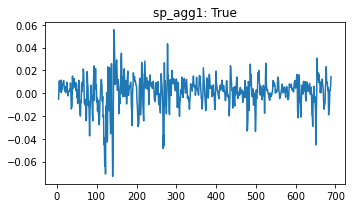

{'vixo': True,
 'naaim_ind': True,
 'ff_M_RF': True,
 'ff_SMB': True,
 'ff_HML': True,
 'ff_RMW': True,
 'ff_CMA': True,
 'termspread': True,
 'pc_ratio': True,
 'aaii_Bullish': True,
 'sp_close': True,
 'sp_close_lead1': True,
 'sp_close_lag1': True,
 'sp_close_lag2': True,
 'sp_close_lag3': True,
 'sp_agg1': True}

In [21]:
# test normality & stationarity
stest = StatsTest(plot=True)

stationarity = stest.df_test_stationarity(x, data_dict["relevant_cols"])
data_dict.update(stationarity=stationarity)

# normality = stest.df_test_normality(df_w, cols=data_dict["relevant_cols"])
# data_dict.update(normality=normality)

stationarity

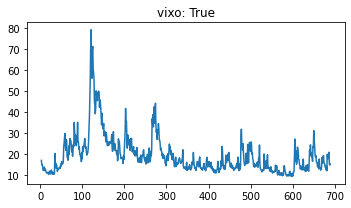

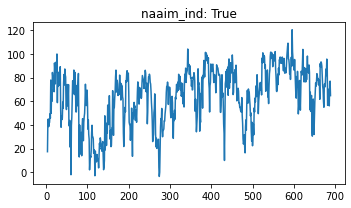

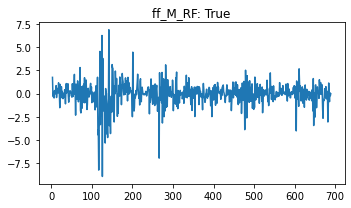

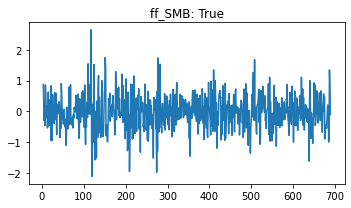

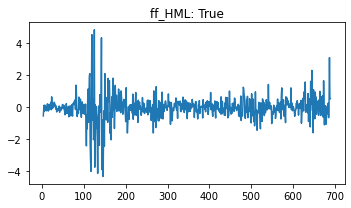

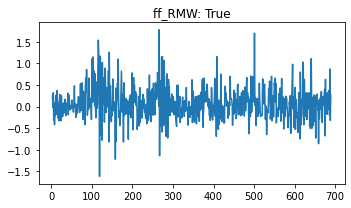

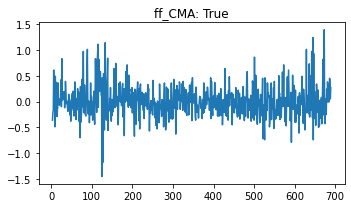

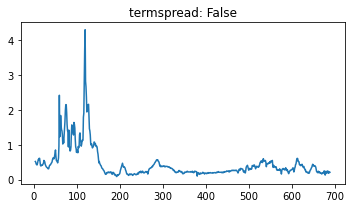

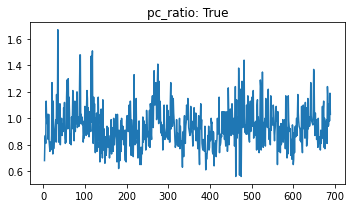

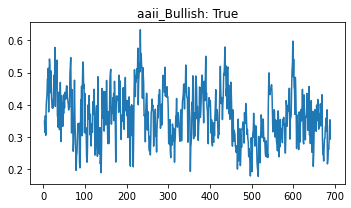

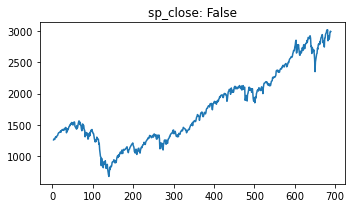

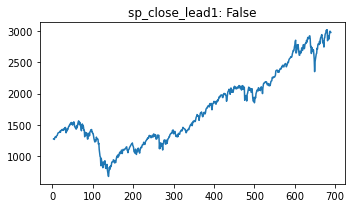

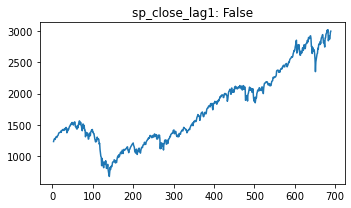

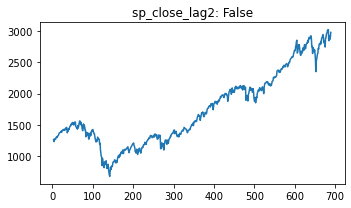

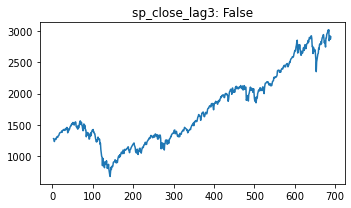

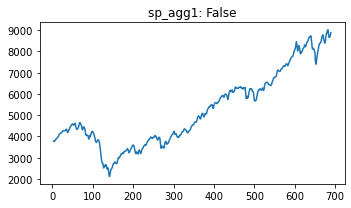

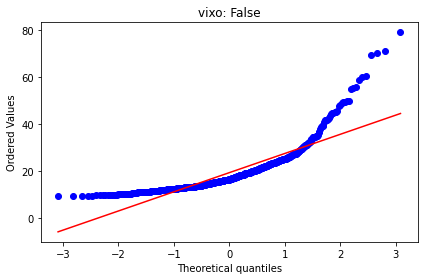

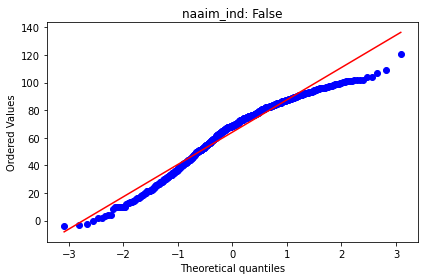

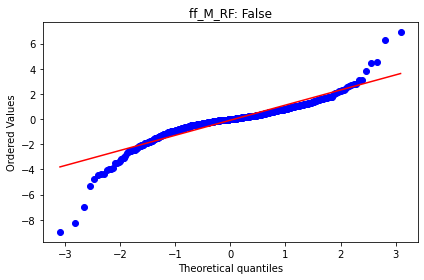

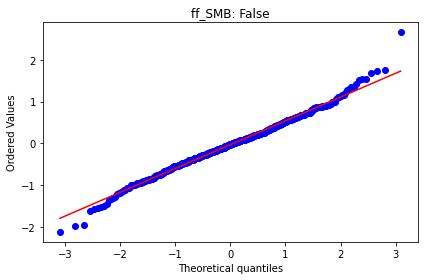

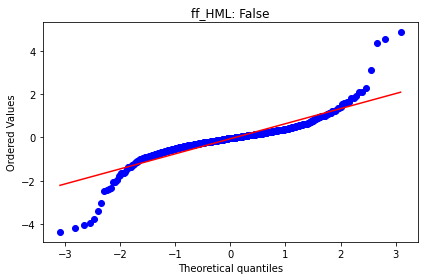

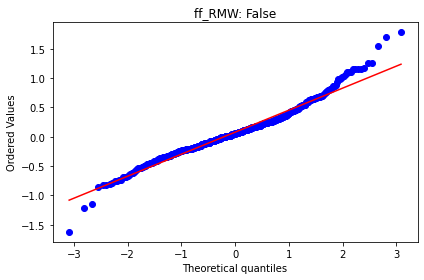

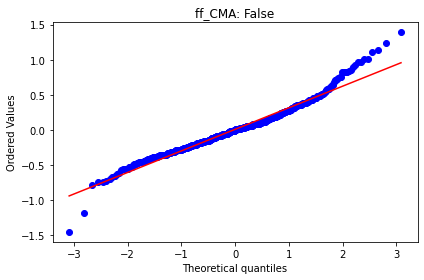

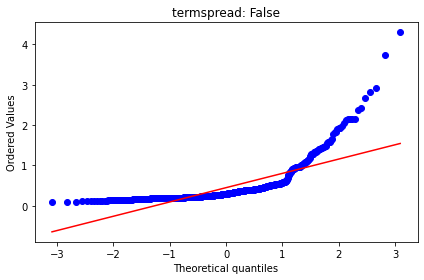

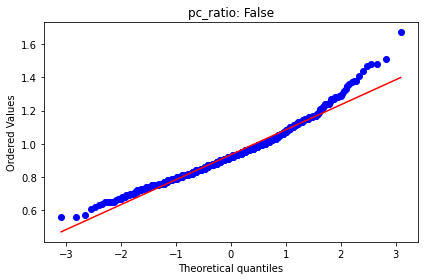

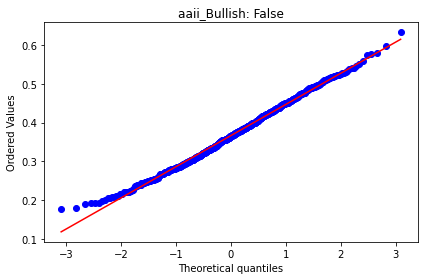

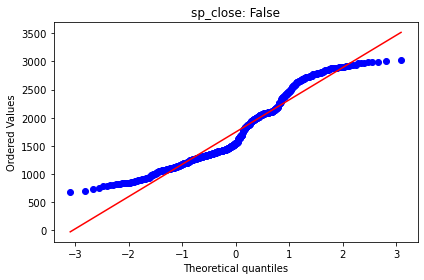

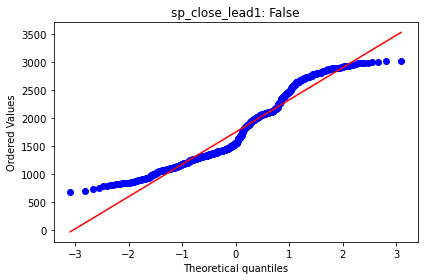

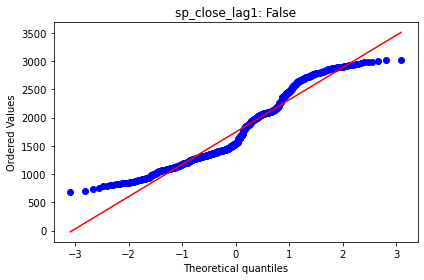

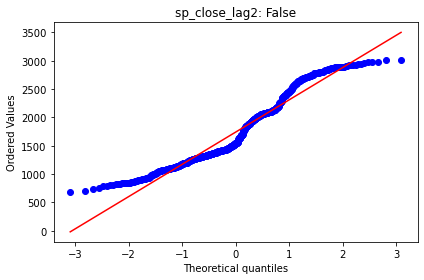

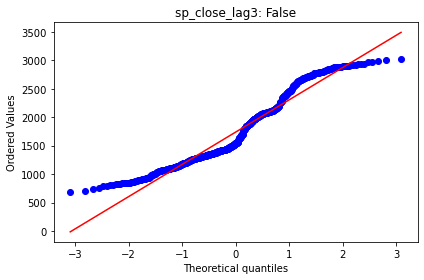

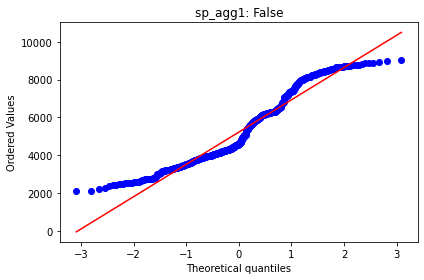

{'vixo': True,
 'naaim_ind': True,
 'ff_M_RF': True,
 'ff_SMB': True,
 'ff_HML': True,
 'ff_RMW': True,
 'ff_CMA': True,
 'termspread': False,
 'pc_ratio': True,
 'aaii_Bullish': True,
 'sp_close': False,
 'sp_close_lead1': False,
 'sp_close_lag1': False,
 'sp_close_lag2': False,
 'sp_close_lag3': False,
 'sp_agg1': False}

In [12]:
# test normality & stationarity
stest = StatsTest(plot=True)

stationarity = stest.df_test_stationarity(df_w, data_dict["relevant_cols"])
data_dict.update(stationarity=stationarity)

# normality = stest.df_test_normality(df_w, cols=data_dict["relevant_cols"])
# data_dict.update(normality=normality)

stationarity

# correlation

In [13]:
# select model features
# predicted lead1
# why ar3 model
cols = [
    'vixo',
     'naaim_ind',
     # 'ff_M_RF',
     # 'ff_SMB',
     # 'ff_RMW',
     # 'ff_CMA',
     # 'termspread',
     # 'pc_ratio',
     'aaii_Bullish',
    # 'ff_HML',
    'sp_close_lag1',
    'sp_close_lag2',
    'sp_agg1',
    # 'goog_sent',
    # 'sp_close_lag3',
    # 'fears35'
]

In [14]:
df_ws = df_w[cols + [data_dict["predicted"]]].copy()

In [17]:
data_dict["lag_correl"] = lag_correl(df_w,
                                     cols,
                                     col_predicted="sp_close_lag1",
                                     show_fig=False)
data_dict["lag_correl"]

[['vixo', 0],
 ['naaim_ind', -1],
 ['aaii_Bullish', -1],
 ['sp_close_lag1', 0],
 ['sp_close_lag2', 0],
 ['sp_agg1', 0]]

In [16]:
df_ws.corr()

,vixo,naaim_ind,aaii_Bullish,sp_close_lag1,sp_close_lag2,sp_agg1,sp_close_lead1
vixo,1.000000,-0.731021,-0.169805,-0.530256,-0.517502,-0.518800,-0.541915
naaim_ind,-0.731021,1.000000,0.272078,0.509960,0.494225,0.495708,0.523957
aaii_Bullish,-0.169805,0.272078,1.000000,-0.166260,-0.179023,-0.176497,-0.141113
sp_close_lag1,-0.530256,0.509960,-0.166260,1.000000,0.997836,0.998916,0.996229
sp_close_lag2,-0.517502,0.494225,-0.179023,0.997836,1.000000,0.999459,0.994696
sp_agg1,-0.518800,0.495708,-0.176497,0.998916,0.999459,1.000000,0.995626
sp_close_lead1,-0.541915,0.523957,-0.141113,0.996229,0.994696,0.995626,1.000000


# Multicolinerarity

,VIF,corr_sp_close_lead1
sp_close_lag2,1.789386,-0.010025
sp_agg1,2.498111,0.013079
sp_close_lag1,2.065137,0.013407
vixo,1.182890,0.047958
aaii_Bullish,1.257932,0.054743
naaim_ind,1.078270,0.064456


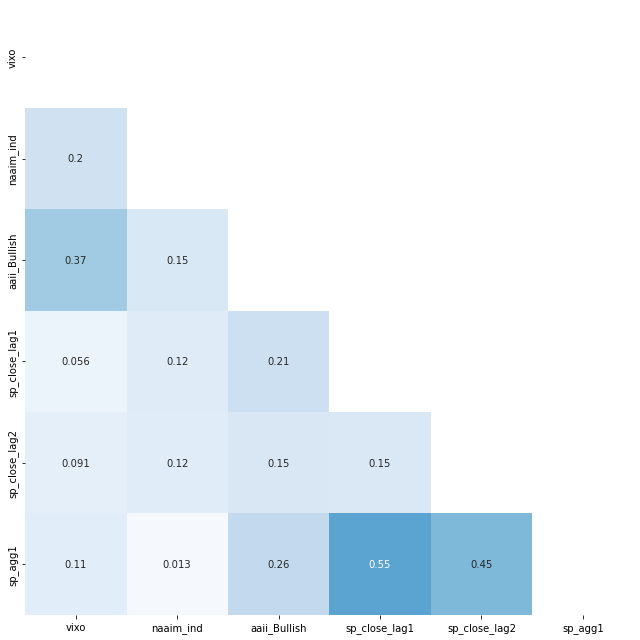

In [46]:
# only rely on correlation not vif
corr_heatmap(df_ws, 
             cols,
             size_factor=1.5,
             show_fig=True)
get_variance_inflation_factor(df_ws, cols, col_pred=data_dict["predicted"])

# Orthogonalise

In [47]:
df_train = df_ws.copy()

,VIF,corr_sp_close_lead1
sp_close_lag2,1.789386,-0.010025
sp_agg1,2.498111,0.013079
sp_close_lag1,2.065137,0.013407
vixo,1.182890,0.047958
aaii_Bullish,1.257932,0.054743
naaim_ind,1.078270,0.064456


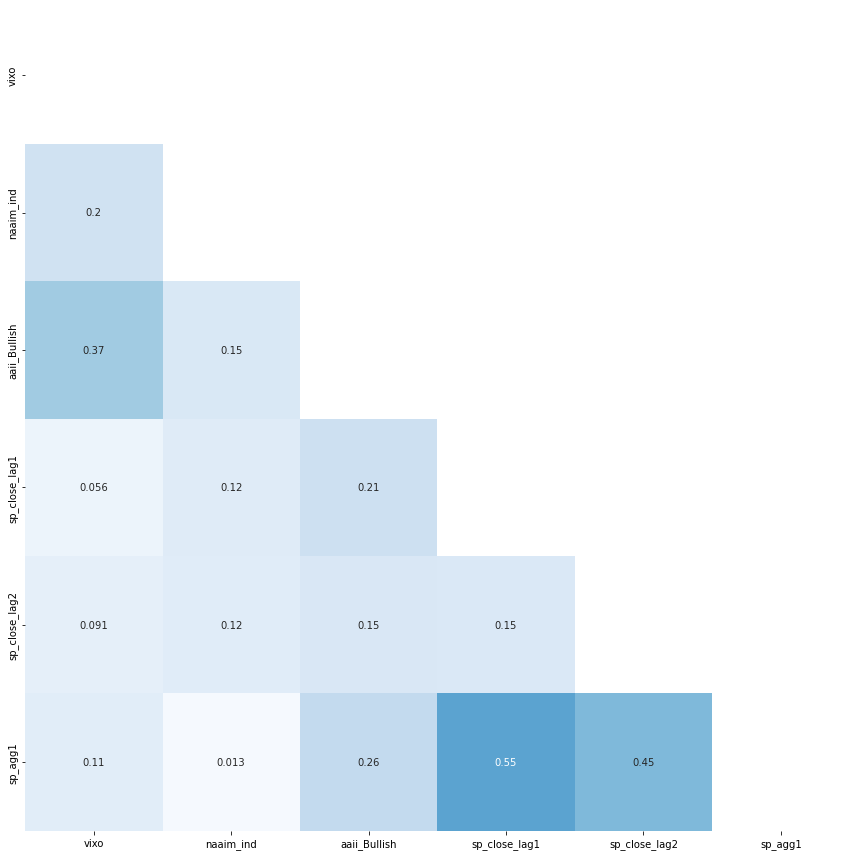

In [48]:
corr_heatmap(df_train, cols,
             size_factor=2,
             show_fig=True)
get_variance_inflation_factor(df_train,
                              cols,
                              col_pred=data_dict["predicted"])

# Regression

In [49]:
X_train, X_test, y_train, y_test = tts_data(df_train, y=data_dict["predicted"], x=cols, random_split=False, test_size=.3)

In [50]:
model = sm.OLS(y_train, X_train, random_state=random_state).fit()

In [51]:
model.pvalues < 0.05

vixo             False
naaim_ind        False
aaii_Bullish     False
sp_close_lag1    False
sp_close_lag2    False
sp_agg1          False
intercept        False
dtype: bool

In [52]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         sp_close_lead1   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                 -0.004
Method:                 Least Squares   F-statistic:                    0.6634
Date:                Wed, 09 Mar 2022   Prob (F-statistic):              0.679
Time:                        12:06:12   Log-Likelihood:                 1033.0
No. Observations:                 480   AIC:                            -2052.
Df Residuals:                     473   BIC:                            -2023.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
vixo              0.0152      0.010      1.461      0.145      -0.005       0.036
naaim_ind         0.0024      0.003      0.717      0.474      -0.004       0.009
aaii_Bullish      0.0114      0.008      1.478      0.140      -0.004       0.027
sp_close_lag1     0.0121      0.066      0.183      0.855      -0.118       0.142
sp_close_lag2    -0.0092      0.061     -0.150      0.881      -0.129       0.111
sp_agg1           0.0624      0.140      0.445      0.656      -0.213       0.338
intercept         0.0009      0.001      0.672      0.502      -0.002       0.003
==============================================================================
Omnibus:                       72.709   Durbin-Watson:                   2.309
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              490.501
Skew:                          -0.417   Prob(JB):                    3.08e-107
Kurtosis:                       7.881   Cond. No.                         119.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Out of sample eval

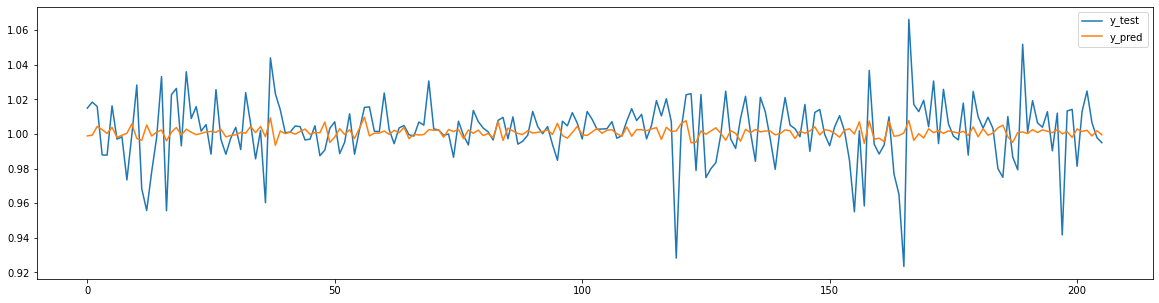

Validation Scores
mean squared error: 0.00031954
mean absolute error: 0.01247614
R2: 0.0319


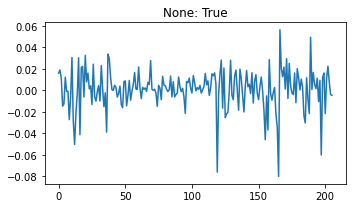

Stationarity Test Results
P-Values: 4.3528528974111956e-27
Test-stats: -14.588485772841512
Time series is stationary: True


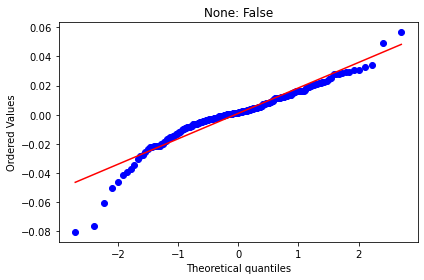

Normality Test Results
P-Values: 3.898869061931342e-12
Test-stats: 52.54066917793328
Series is normally distributed: False


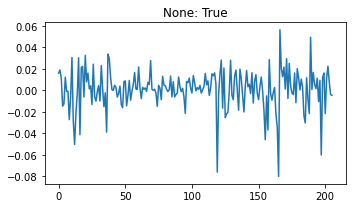

Test for Heteroskedasticity
Test p-value: 0.00027320326507642134
Heteroskedasticity is present: True


In [53]:
# ar1 model als baseline
# add variables progressively, to obtain best
# random walk with drift, as benchmark model
# take root mean squared error as metrics
mval = ModelValidation(X_test,
                y_test,
                model,
                data_dict)
mval.get_model_performance()
mval.analyse_resids(print_results=True)

# Plot results

In [41]:
df_r = df_w.loc[df_ws.index].reset_index(drop=True).copy()

In [42]:
df_r["sp_tot_pred_test"] = np.concatenate([np.array(list([np.nan] * len(model.predict()))),
                                            mval.pred_inv.values]) * df_r["sp_true_vals"]

df_r["sp_tot_pred_train"] = np.concatenate([arr_inv_log_returns(model.predict()),
                                            np.array(list([np.nan] * len(mval.pred_inv.values)))]) * df_r["sp_true_vals"]

df_r["sp_tot_pred_train"] = df_r["sp_tot_pred_train"].shift(1)
df_r["sp_tot_pred_test"] = df_r["sp_tot_pred_test"].shift(1)

Validation Scores Test Data
mean squared error: 2128.0799537584962
mean absolute error: 31.67014276372481
mean absolute error %: 1.8126753453816873


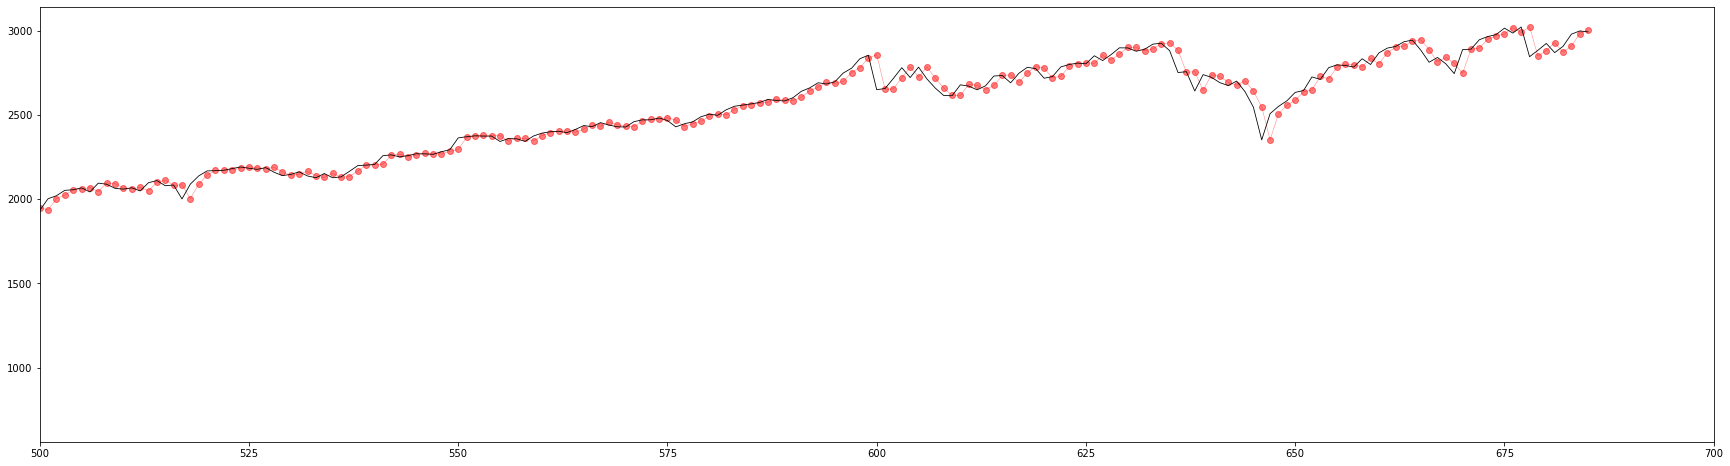

In [44]:
fig, ax = plt.subplots(1, 1, figsize=(30, 8))
ax.plot(df_r["sp_tot_pred_train"], marker="o", lw=.5, alpha=.3, color="blue")
ax.plot(df_r["sp_tot_pred_test"], marker="o", lw=.5, alpha=.5, color="red")
ax.plot(df_r["sp_true_vals"], color="black", lw=.8)

plt.xlim([500, 700])

print("Validation Scores Test Data")
print(f"mean squared error: {np.mean((df_r.sp_tot_pred_test - df_r[data_dict['sp_true_vals']]) ** 2)}")
print(f"mean absolute error: {np.mean(abs(df_r.sp_tot_pred_test - df_r[data_dict['sp_true_vals']]))}")
print(f"mean absolute error %: {(np.mean(abs(df_r.sp_tot_pred_test - df_r[data_dict['sp_true_vals']])) / df_r[data_dict['sp_true_vals']].mean()) * 100}")

# Save model

In [28]:
save_model(df_train, model, mval, data_dict, name="four_features_vixo_splag_splagmul_pcr_ffMRF", file_path=OUT_MODEL_DIR)

Are you sure you want to save model as: f"2022-03-08_four_features_vixo_splag_splagmul_pcr_ffMRF_model.pkl"? (y/n)


 y
